FloatSlider(value=81.0, description='Thrust T (N):', max=150.0)

FloatSlider(value=0.0, description='Nozzle φ (rad):', max=0.5, min=-0.5, step=0.01)

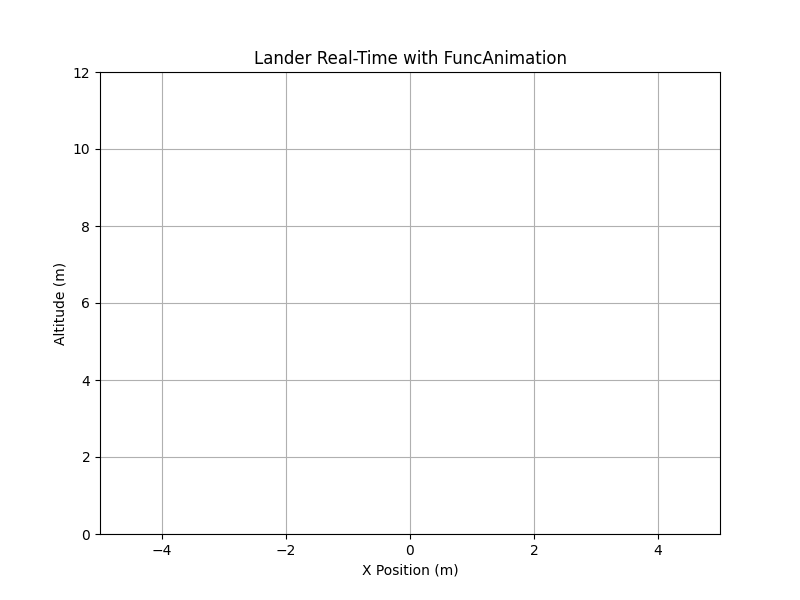

In [23]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
from IPython.display import display
import time

# System setup
m, I, g, l_1, T_max = 50, 2.5, 1.62, 0.5, 150
dt = 0.05   # Simulation timestep (physics)
T_total = 120
steps = int(T_total / dt)

A = np.array([[0, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, g, 0],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 1],
              [0, 0, 0, 0, 0, 0]])

B = np.array([[0, 0],
              [0, g],
              [0, 0],
              [-1/m, 0],
              [0, 0],
              [0, m * g * l_1 / I]])

X = np.zeros(6)
X[2] = 10  # Initial altitude

# Plot setup
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(-5, 5)
ax.set_ylim(0, 12)
ax.set_xlabel("X Position (m)")
ax.set_ylabel("Altitude (m)")
ax.set_title("Lander Real-Time with FuncAnimation")
ax.grid(True)
lander_body, = ax.plot([], [], 'ks-', lw=2, markersize=8, markerfacecolor='k')
nozzle_plot, = ax.plot([], [], 'r-', lw=2)

# Interactive sliders
thrust_slider = widgets.FloatSlider(value=m * g, min=0, max=T_max, step=0.1, description='Thrust T (N):')
phi_slider = widgets.FloatSlider(value=0, min=-0.5, max=0.5, step=0.01, description='Nozzle φ (rad):')
display(thrust_slider, phi_slider)

lander_shape = np.array([[-0.4, 0.4, 0.4, -0.4, -0.4],
                         [-0.6, -0.6, 0.6, 0.6, -0.6]])
nozzle_length = 1.0
lander_height = 1.2

# Timing management for real-time
start_wall_time = time.perf_counter()
sim_time = 0.0

def rk4_step(X, u, dt):
    k1 = A @ X + B @ u
    k2 = A @ (X + 0.5 * dt * k1) + B @ u
    k3 = A @ (X + 0.5 * dt * k2) + B @ u
    k4 = A @ (X + dt * k3) + B @ u
    return X + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

def update(frame):
    global X, sim_time
    # Compute the desired simulation time based on real-world time passed
    real_elapsed = time.perf_counter() - start_wall_time
    while sim_time < real_elapsed:
        # Advance physics until sim_time catches up with real time
        T_val = thrust_slider.value
        phi_val = phi_slider.value
        delta_T = m * g - T_val
        u = np.array([delta_T, phi_val])
        X = rk4_step(X, u, dt)
        sim_time += dt

    # Extract state
    x_pos, altitude, theta = X[0], X[2], X[4]

    # Lander rotation and translation
    R = np.array([[np.cos(-theta), -np.sin(-theta)],
                  [np.sin(-theta),  np.cos(-theta)]])
    lander_coords = R @ lander_shape
    lander_body.set_data(lander_coords[0, :] + x_pos, lander_coords[1, :] + altitude)

    # Nozzle
    nozzle_base = np.array([0, -lander_height / 2])
    nozzle_tip = nozzle_base + np.array([np.sin(phi_val), -np.cos(phi_val)]) * nozzle_length
    nozzle_world_base = R @ nozzle_base + np.array([x_pos, altitude])
    nozzle_world_tip = R @ nozzle_tip + np.array([x_pos, altitude])
    nozzle_plot.set_data([nozzle_world_base[0], nozzle_world_tip[0]],
                         [nozzle_world_base[1], nozzle_world_tip[1]])

    ax.set_title(f'Altitude: {altitude:.2f} m | θ: {theta:.2f} rad | φ: {phi_val:.2f} rad')
    return lander_body, nozzle_plot

# FuncAnimation: frame rate controls only *how often* the screen updates
ani = FuncAnimation(fig, update, frames=steps, interval=50, blit=True)
plt.show()